In [2]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [4]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2022-09-09 11:50:18--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.240, 142.250.80.48, 142.251.40.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  28.0MB/s    in 5.6s    

2022-09-09 11:50:24 (24.4 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2022-09-09 11:50:24--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.80.16, 142.250.80.48, 142.251.40.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.80.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================>]  

In [5]:
!mkdir beans

In [6]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/


Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [8]:
!rm test.zip train.zip validation.zip

rm: validation.zip: No such file or directory


In [9]:
!ls beans

test       train      validation


In [10]:
!find beans -type f | wc -l

    1296


In [11]:
!find beans/test -type f | wc -l

     128


In [12]:
!find beans/validation -type f | wc -l

     133


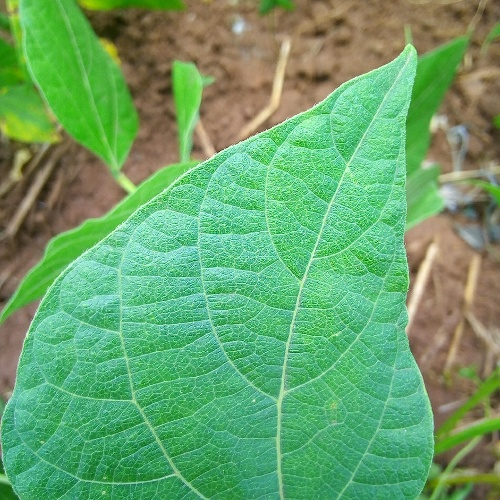

In [13]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

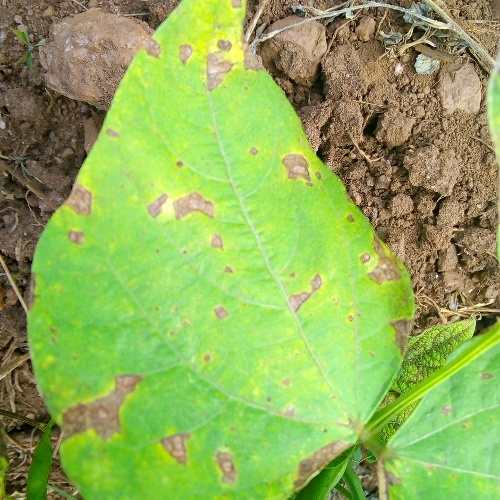

In [14]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.124.jpg'))

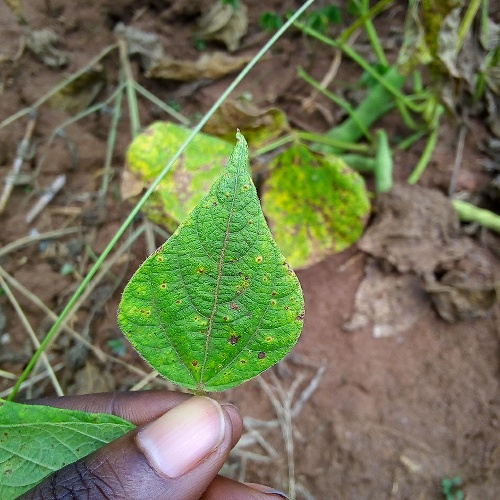

In [15]:
display(Image('beans/train/bean_rust/bean_rust_train.162.jpg'))

In [16]:
batch_size = 128
img_height = 224
img_width = 224

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.


2022-09-09 11:54:38.524158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [21]:
classes=train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


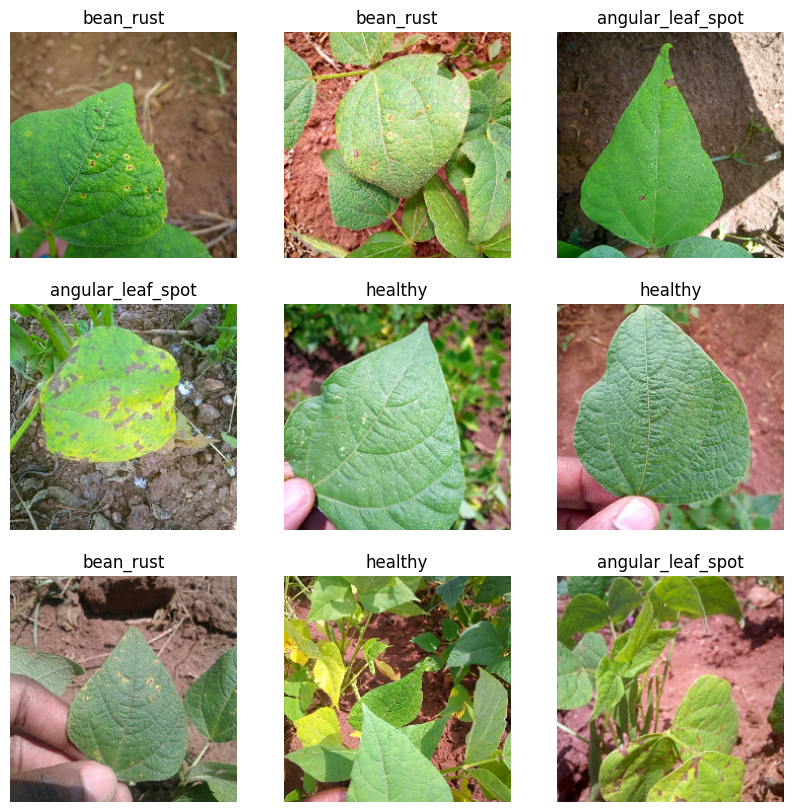

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [25]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [26]:
feature_extractor_layer.trainable = False

In [27]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
tf.random.set_seed(111)

In [29]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 17s 1s/step - loss: 1.1848 - accuracy: 0.4265 - val_loss: 0.7921 - val_accuracy: 0.6316
Epoch 2/20
9/9 [==============================] - 12s 1s/step - loss: 0.8279 - accuracy: 0.6238 - val_loss: 0.6081 - val_accuracy: 0.7669
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: 0.6665 - accuracy: 0.6992 - val_loss: 0.5180 - val_accuracy: 0.8045
Epoch 4/20
9/9 [==============================] - 11s 1s/step - loss: 0.5530 - accuracy: 0.7853 - val_loss: 0.4619 - val_accuracy: 0.8271
Epoch 5/20
9/9 [==============================] - 9s 1s/step - loss: 0.5074 - accuracy: 0.8056 - val_loss: 0.4260 - val_accuracy: 0.8195
Epoch 6/20
9/9 [==============================] - 9s 1s/step - loss: 0.4699 - accuracy: 0.8162 - val_loss: 0.3959 - val_accuracy: 0.8496
Epoch 7/20
9/9 [==============================] - 9s 1s/step - loss: 0.4316 - accuracy: 0.8308 - val_loss: 0.3762 - val_accuracy: 0.8421
Epoch 8/20
9/9 [=====================

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


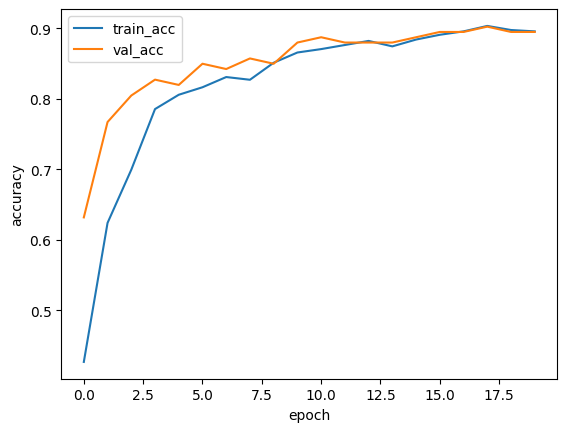

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [34]:
result=model.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.2617 - accuracy: 0.8984


1/1 [==============================] - 0s 67ms/step


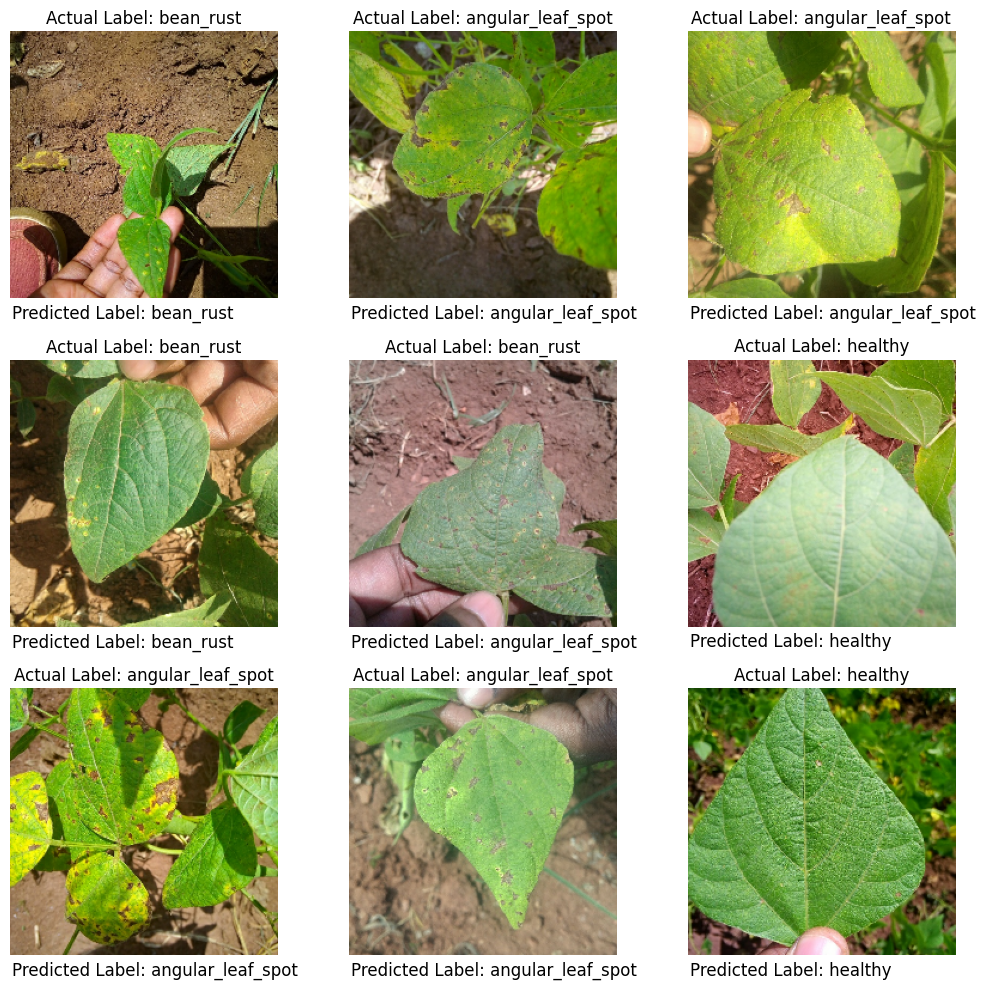

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [36]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [37]:
!ls -alrt models

total 3744
drwxr-xr-x  8 jaganlalthoppe  staff      256 Sep  9 12:26 ..
drwxr-xr-x  4 jaganlalthoppe  staff      128 Sep  9 12:26 variables
drwxr-xr-x  2 jaganlalthoppe  staff       64 Sep  9 12:26 assets
-rw-r--r--  1 jaganlalthoppe  staff  1906386 Sep  9 12:26 saved_model.pb
drwxr-xr-x  6 jaganlalthoppe  staff      192 Sep  9 12:26 .
-rw-r--r--  1 jaganlalthoppe  staff     7425 Sep  9 12:26 keras_metadata.pb


In [38]:
model_loaded = tf.keras.models.load_model('./models/')

In [39]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [41]:
pred_label=model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

1/1 [==============================] - 1s 617ms/step
healthy


In [42]:
pred_label

array([[7.0687151e-04, 5.5248562e-02, 9.4404453e-01]], dtype=float32)